In [24]:
# 数据处理
import pandas as pd
import os
import numpy as np
import cv2
from PIL import Image

image_size = 224          # 指定图片大小
path = './Animals_with_Attributes2/'   #文件读取路径

# 两个字典，记录标签信息，分别是数字对应到文字，文字对应到数字
classname = pd.read_csv(path+'classes.txt',header=None,sep = '\t')
dic_class2name = {classname.index[i]:classname.loc[i][1] for i in range(classname.shape[0])}    
dic_name2class = {classname.loc[i][1]:classname.index[i] for i in range(classname.shape[0])}

all_features = []
all_labels = []
with open( './Animals_with_Attributes2/Features/ResNet101/AwA2-features.txt', 'r' ) as f:
    contents = f.read()
    contents = contents.split('\n')[0:-1]
    # print(contents[-1])
    for content in contents:
        content_line = [float(x) for x in content.split(' ')]
        all_features.append(content_line)

with open('./Animals_with_Attributes2/Features/ResNet101/AwA2-labels.txt', 'r') as f:
    contents = f.read()
    contents = contents.split('\n')[0:-1]
    # print(len(contents))
    for content in contents:
        all_labels.append(int(content))


all_features = np.array(all_features)
all_labels = np.array(all_labels)

print(all_features.shape)
print(all_labels.shape)

train_category = []
test_category = []

with open('./Animals_with_Attributes2/trainclasses.txt', 'r') as f:
    contents = f.read()
    contents = contents.split('\n')
    for content in contents:
        train_category.append(dic_name2class[content]+1)


with open('./Animals_with_Attributes2/testclasses.txt', 'r') as f:
    contents = f.read()
    contents = contents.split('\n')
    for content in contents:
        test_category.append(dic_name2class[content]+1)

train_features = []
train_labels = []
test_features = []
test_labels = []

for i in range(all_features.shape[0]):
    if all_labels[i] in train_category:
        train_features.append(all_features[i])
        train_labels.append(all_labels[i])
    else:
        test_features.append(all_features[i])
        test_labels.append(all_labels[i])


train_features = np.array(train_features)
train_labels = np.array(train_labels)
test_features = np.array(test_features)
test_labels = np.array(test_labels)

# 测试集应该有 6985 张图片，训练集应该有30337张图片
print('train_features: {}, train_labels: {}, test_features: {}, test_labels: {}'.format(train_features.shape, train_labels.shape, test_features.shape, test_labels.shape))

(37322, 2048)
(37322,)
train_features: (30337, 2048), train_labels: (30337,), test_features: (6985, 2048), test_labels: (6985,)


In [ ]:
# Semantic relatedness methods

# 确定依据的维度，是85维
# with open('./Animals_with_Attributes2/predicate-matrix-binary.txt', 'r') as f:
#     contents = f.read()
#     contents = contents.split('\n')
    
#     content = contents[0]
#     content = content.split(' ')
#     print(len(content))

# 打印完整数组
np.set_printoptions(threshold=np.inf)

# 初始化 51*51 的相似度矩阵
similarity_matrix = np.full(2601, -1, dtype=float).reshape(51, 51)

# 初始化 51*85 的依据，predicates[i]是类别i的依据
predicates_num = 85
predicates = np.arange(51*predicates_num).reshape(51, predicates_num)

with open('./Animals_with_Attributes2/predicate-matrix-binary.txt', 'r') as f:
    contents = f.read()
    contents = contents.split('\n') # 应该是50个01字符串
    
    for i in range(1,51):
        content = contents[i-1]
        content = np.array(content.split(' '))
        predicates[[i],:]=content # 将content直接赋值给依据的第i行

# print(predicates)

def similarity_compare(arr1, arr2): # 对比两个向量的相似度
    count = 0
    for i in range(arr1.shape[0]):
        if arr1[i]==arr2[i]:
            count += 1
    
    return count

def normalization(similarity_matrix): # 按行进行归一化
    for i in range(1, similarity_matrix.shape[0]):
        sum = similarity_matrix[i, 1:].sum()
        similarity_matrix[i, 1:] /= sum

for i in range(1,51):
    for j in range(i,51):
        similarity = similarity_compare(predicates[i,:], predicates[j,:])
        similarity_matrix[i, j] = similarity
        similarity_matrix[j, i] = similarity

# print(similarity_matrix)

# normalization(similarity_matrix)
# print(similarity_matrix)

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(multi_class='ovr')
model.fit(train_features, train_labels)

y_pred_proba = model.predict_proba(test_features)

# 初始化实际标签(50维) 到预测标签(40维)的转换数组
five2four = np.arange(51)
five2four[0] = -1
count = 0
for i in range(1,51):
    if i in train_category:
        five2four[i] = count
        count += 1
    else:
        five2four[i] = -1

# print(five2four)

t = 0.0
t_all = 0.0
for x in range(test_labels.shape[0]):
    prob = np.arange(10) # 属于十个测试类别的概率
    prob_norm = np.arange(10)
    for i in range(10):
        category = test_category[i] # 当前的测试类别
        prob_tmp = 0.0
        # simi_weight = 0.0
        for j in range(40):
            t_category = train_category[j] # 待评价的训练类别
            prob_tmp += similarity_matrix[category, t_category] * y_pred_proba[x, five2four[t_category]] #查询他们的相似度，并乘以在该训练类别的预测概率
            # simi_weight += similarity_matrix[category, t_category]

        prob[i] = prob_tmp
        # prob_norm[i] = prob_tmp / simi_weight
    

    pred = test_category[prob.argmax()] # 取最大概率对应的类作为预测类
    if pred == test_labels[x] : # 如果和标签相同，认为10分类预测正确
        t += 1
        if prob_norm[prob.argmax()]>=y_pred_proba[x].max(): # 如果是所有类别中标签最大的，则认为50分类预测正确
            t_all += 1

print('10 class accuracy : {}'.format(t/test_labels.shape[0]))
# print('50 class accuracy : {}'.format(t_all/test_labels.shape[0]))

In [ ]:
# Semantic relatedness methods 绘图代码

# 打印完整数组
np.set_printoptions(threshold=np.inf)

# 初始化 51*51 的相似度矩阵
similarity_matrix = np.full(2601, -1, dtype=float).reshape(51, 51)

# 初始化 51*85 的依据，predicates[i]是类别i的依据
predicates_num = 85
predicates = np.arange(51*predicates_num).reshape(51, predicates_num)

with open('./Animals_with_Attributes2/predicate-matrix-binary.txt', 'r') as f:
    contents = f.read()
    contents = contents.split('\n') # 应该是50个01字符串
    
    for i in range(1,51):
        content = contents[i-1]
        content = np.array(content.split(' '))
        predicates[[i],:]=content # 将content直接赋值给依据的第i行

# print(predicates)

def similarity_compare(arr1, arr2): # 对比两个向量的相似度
    count = 0
    for i in range(arr1.shape[0]):
        if arr1[i]==arr2[i]:
            count += 1
    
    return count

def normalization(similarity_matrix): # 按行进行归一化
    for i in range(1, similarity_matrix.shape[0]):
        sum = similarity_matrix[i, 1:].sum()
        similarity_matrix[i, 1:] /= sum

for i in range(1,51):
    for j in range(i,51):
        similarity = similarity_compare(predicates[i,:], predicates[j,:])
        similarity_matrix[i, j] = similarity
        similarity_matrix[j, i] = similarity

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(multi_class='ovr')
model.fit(train_features, train_labels)

y_pred_proba = model.predict_proba(test_features)

# 初始化实际标签(50维) 到预测标签(40维)的转换数组
five2four = np.arange(51)
five2four[0] = -1
count = 0
for i in range(1,51):
    if i in train_category:
        five2four[i] = count
        count += 1
    else:
        five2four[i] = -1

# print(five2four)
################################ 画图部分

plt_x = []
plt_y = []
for alpha in np.arange(0, 1, 0.01):
    t = 0.0
    t_all = 0.0
    for x in range(test_labels.shape[0]):
        prob = np.arange(10) # 属于十个测试类别的概率
        prob_norm = np.arange(10)
        for i in range(10):
            category = test_category[i] # 当前的测试类别
            prob_tmp = 0.0
            # simi_weight = 0.0
            for j in range(40):
                t_category = train_category[j] # 待评价的训练类别
                prob_tmp += similarity_matrix[category, t_category] * y_pred_proba[x, five2four[t_category]] * alpha #查询他们的相似度，并乘以在该训练类别的预测概率
                # simi_weight += similarity_matrix[category, t_category]

            prob[i] = prob_tmp
            # prob_norm[i] = prob_tmp / simi_weight
        

        pred = test_category[prob.argmax()] # 取最大概率对应的类作为预测类
        if pred == test_labels[x] : # 如果和标签相同，认为10分类预测正确
            t += 1
            if prob_norm[prob.argmax()]>=y_pred_proba[x].max(): # 如果是所有类别中标签最大的，则认为50分类预测正确
                t_all += 1

    plt_x.append(alpha)
    plt_y.append(t/test_labels.shape[0])
    print('10 class accuracy : {}, alpha is {}'.format(t/test_labels.shape[0], alpha))
# print('50 class accuracy : {}'.format(t_all/test_labels.shape[0]))

import matplotlib.pyplot as plt
# plt.rcParams['font.sans-serif']=['SimHei']
# plt.rcParams['axes.unicode_minus'] = False
plt.plot(plt_x, plt_y)
plt.xlabel('alpha')
plt.ylabel('test accuracy')

In [17]:
# Semantic embedding methods : ||Px-a||
from sklearn.linear_model import LinearRegression

# 初始化 51*85 的依据，predicates[i]是类别i的依据
predicates_num = 85
predicates = np.arange(51*predicates_num, dtype=float).reshape(51, predicates_num)

with open('./Animals_with_Attributes2/predicate-matrix-continuous.txt', 'r') as f:
    contents = f.read()
    contents = contents.split('\n') # 应该是50个字符串
    
    for i in range(1,51):
        content = contents[i-1]
        content = np.array(content.split()) # split 默认删掉所有空格
        predicates[[i],:]=content # 将content直接赋值给依据的第i行

train_predicates = []

for i in range(train_labels.shape[0]):
    train_predicates.append(predicates[train_labels[i]])

train_predicates = np.array(train_predicates)

model = LinearRegression(fit_intercept=False)
model.fit(train_features, train_predicates)
y_pred = model.predict(test_features)

t = 0.0
for x in range(y_pred.shape[0]):
    minDist = 1e4
    minClass = -1
    for i in range(10):
        dist=np.linalg.norm(y_pred[x]-predicates[test_category[i]]) # 计算真实依据和预测依据的欧式距离(二范数)
        if dist < minDist:
            minDist = dist
            minClass = test_category[i]
    
    if minClass == test_labels[x]:
        # print('min class : {}, test_labels : {}'.format(minClass, test_labels[x]))
        t += 1

print('10 class accuracy : {}'.format(t/test_labels.shape[0]))


10 class accuracy : 0.6320687186828919


In [2]:
# Semantic embedding methods : ||X^TMA-Y||2F + ...
# train_features: X^T
# predicates: A^T
# train_labels_onehot: Y

np.set_printoptions(threshold=np.inf)
# print(train_labels)
# 初始化实际标签(50维) 到预测标签(40维)的转换数组
five2four = np.arange(51)
five2four[0] = -1
count = 0
for i in range(1,51):
    if i in train_category:
        five2four[i] = count
        count += 1
    else:
        five2four[i] = -1

predicates_num = 85
predicates = np.arange(40*predicates_num, dtype=float).reshape(40, predicates_num)

with open('./Animals_with_Attributes2/predicate-matrix-continuous.txt', 'r') as f:
    contents = f.read()
    contents = contents.split('\n') # 应该是50个字符串
    
    for i in range(1, 51):
        if five2four[i] != -1: # 如果是训练集中的类，将其类别标签转换为40种类别的标签
            content = contents[i-1]
            content = np.array(content.split()) # split 默认删掉所有空格
            predicates[[five2four[i]],:]=content # 将content直接赋值给依据的第i行

# print(predicates)

# print(train_labels)
for i in range(train_labels.shape[0]): # 将标签转为40维度的标签
    train_labels[i] = five2four[train_labels[i]]

train_labels_onehot = np.eye(40)[train_labels]

# print(train_labels_onehot.shape)

train_features = np.mat(train_features)
predicates = np.mat(predicates)
train_labels_onehot = np.mat(train_labels_onehot)

lambda1 = 1
lambda2 = 1

# XX^T 是 2048*2048 维的矩阵
tmp1 = train_features.T * train_features + lambda1 * np.eye(2048)
# AA^T 是 85*85 维的矩阵
tmp2 = predicates.T * predicates + lambda2 * np.eye(85)

# 从左到右依次维 2048*2048 2048*n n*40 40*85 85*85
M = np.linalg.inv(tmp1) * train_features.T * train_labels_onehot * predicates * np.linalg.inv(tmp2)

# print(M.shape)

# print(M)

# print(train_labels)
# print(train_labels_onehot)

# 初始化实际标签(50维) 到预测标签(10维)的转换数组
five2ten = np.arange(51)
five2ten[0] = -1
count = 0
for i in range(1,51):
    if i in test_category:
        five2ten[i] = count
        count += 1
    else:
        five2ten[i] = -1

# 测试集的依据
predicates_test = np.arange(10*predicates_num, dtype=float).reshape(10, predicates_num)

with open('./Animals_with_Attributes2/predicate-matrix-continuous.txt', 'r') as f:
    contents = f.read()
    contents = contents.split('\n') # 应该是50个字符串
    
    for i in range(1, 51):
        if five2ten[i] != -1: # 如果是训练集中的类，将其类别标签转换为10种类别的标签
            content = contents[i-1]
            content = np.array(content.split()) # split 默认删掉所有空格
            predicates_test[[five2ten[i]],:]=content # 将content直接赋值给依据的第i行

# print(predicates_test)
# predicates_test 10 * 85
predicates_test = np.mat(predicates_test)

t = 0.0
for i in range(test_labels.shape[0]):
    test_x = np.mat(test_features[i]) # 取出数据的feature，大小为 1*2048
    y_pred = test_x * M * predicates_test.T # 得到 1*10 的预测向量
    
    sub = y_pred.argmax() # 找到最大的向量对应的类别
    pred_class = np.where(five2ten==sub)[0][0] # 转回50类别
    # print('pred class : {}, sub : {}, true: {}'.format(pred_class, sub, test_labels[i]))
    if pred_class == test_labels[i]:
        t += 1

print('10 class accuracy : {}'.format(t/test_labels.shape[0]))

10 class accuracy : 0.5098067287043665


In [ ]:
# Semantic embedding methods : ||X^TMA-Y||2F + ... 绘图代码
np.set_printoptions(threshold=np.inf)
# print(train_labels)
# 初始化实际标签(50维) 到预测标签(40维)的转换数组
five2four = np.arange(51)
five2four[0] = -1
count = 0
for i in range(1,51):
    if i in train_category:
        five2four[i] = count
        count += 1
    else:
        five2four[i] = -1

predicates_num = 85
predicates = np.arange(40*predicates_num, dtype=float).reshape(40, predicates_num)

with open('./Animals_with_Attributes2/predicate-matrix-continuous.txt', 'r') as f:
    contents = f.read()
    contents = contents.split('\n') # 应该是50个字符串
    
    for i in range(1, 51):
        if five2four[i] != -1: # 如果是训练集中的类，将其类别标签转换为40种类别的标签
            content = contents[i-1]
            content = np.array(content.split()) # split 默认删掉所有空格
            predicates[[five2four[i]],:]=content # 将content直接赋值给依据的第i行

# print(predicates)

# print(train_labels)
for i in range(train_labels.shape[0]): # 将标签转为40维度的标签
    train_labels[i] = five2four[train_labels[i]]

train_labels_onehot = np.eye(40)[train_labels]

# print(train_labels_onehot.shape)

train_features = np.mat(train_features)
predicates = np.mat(predicates)
train_labels_onehot = np.mat(train_labels_onehot)

# 初始化实际标签(50维) 到预测标签(10维)的转换数组
five2ten = np.arange(51)
five2ten[0] = -1
count = 0
for i in range(1,51):
    if i in test_category:
        five2ten[i] = count
        count += 1
    else:
        five2ten[i] = -1

# 测试集的依据
predicates_test = np.arange(10*predicates_num, dtype=float).reshape(10, predicates_num)

with open('./Animals_with_Attributes2/predicate-matrix-continuous.txt', 'r') as f:
    contents = f.read()
    contents = contents.split('\n') # 应该是50个字符串
    
    for i in range(1, 51):
        if five2ten[i] != -1: # 如果是训练集中的类，将其类别标签转换为10种类别的标签
            content = contents[i-1]
            content = np.array(content.split()) # split 默认删掉所有空格
            predicates_test[[five2ten[i]],:]=content # 将content直接赋值给依据的第i行

predicates_test = np.mat(predicates_test)

z_val = np.arange(100, dtype=float).reshape(10,10)
x_posotion = 0
y_posotion = 0

for lambda1 in np.arange(0, 0.1, 0.01):
    for lambda2 in np.arange(0, 0.1, 0.01):
        # XX^T 是 2048*2048 维的矩阵
        tmp1 = train_features.T * train_features + lambda1 * np.eye(2048)
        # AA^T 是 85*85 维的矩阵
        tmp2 = predicates.T * predicates + lambda2 * np.eye(85)

        # 从左到右依次维 2048*2048 2048*n n*40 40*85 85*85
        M = np.linalg.inv(tmp1) * train_features.T * train_labels_onehot * predicates * np.linalg.inv(tmp2)

        t = 0.0
        for i in range(test_labels.shape[0]):
            test_x = np.mat(test_features[i]) # 取出数据的feature，大小为 1*2048
            y_pred = test_x * M * predicates_test.T # 得到 1*10 的预测向量
            
            sub = y_pred.argmax() # 找到最大的向量对应的类别
            pred_class = np.where(five2ten==sub)[0][0] # 转回50类别
            if pred_class == test_labels[i]:
                t += 1
        
        z_val[x_posotion, y_posotion] = t/test_labels.shape[0]
        y_posotion += 1

        print('10 class accuracy : {}, lambda1 : {}, lambda2 : {}'.format(t/test_labels.shape[0], lambda1, lambda2))
    x_posotion += 1
    y_posotion = 0

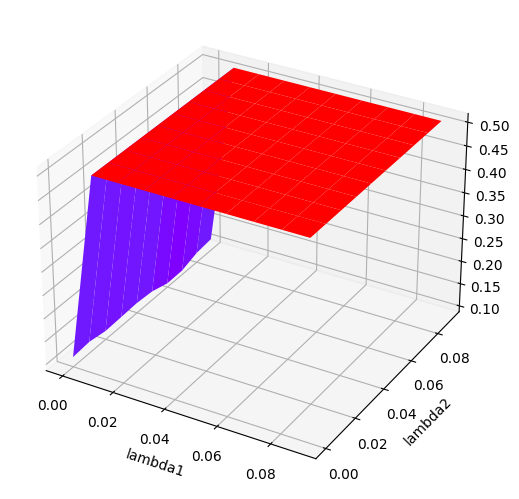

In [30]:
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
figure = plt.figure()
ax = figure.add_axes(Axes3D(figure))# 设置图像为三维格式
X = np.arange(0,0.1,0.01) # lambda1的范围
Y = np.arange(0,0.1,0.01) # lambda2的范围
X,Y = np.meshgrid(X,Y) # 绘制网格
# Z=(np.sin(X)*np.sin(Y))/(X*Y) # F(X,Y)=sin(X)*sin(Y)/(X*Y)
ax.plot_surface(X,Y,z_val,rstride=1,cstride=1,cmap='rainbow') # 绘制3D图，后面的参数为调节图像的格式
plt.xlabel('lambda1')
plt.ylabel('lambda2')

plt.show() # 展示图片

# print(z_val[0,0])

In [ ]:
# GCN 训练
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.utils import  save_image
import torch.autograd
from torch.autograd import Variable
import os
from torch.utils.tensorboard import SummaryWriter

# 超参数定义
epoch_num = 100


######################## 网络定义
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator,self).__init__()
        self.dis = nn.Sequential(
            nn.Linear(2048 + 85,2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048,2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048,512),
            nn.LeakyReLU(0.2),
            nn.Linear(512,1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.dis(x)
        return x
    
class generator(nn.Module):
    
    def __init__(self):
        super(generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(100 + 85, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 2048)
        )
 
    def forward(self, x):
        x = self.gen(x)
        return x

######################## 数据初始化
# 生成 train_predicates
predicates_num = 85
predicates = np.arange(51*predicates_num, dtype=float).reshape(51, predicates_num)

with open('./Animals_with_Attributes2/predicate-matrix-continuous.txt', 'r') as f:
    contents = f.read()
    contents = contents.split('\n') # 应该是50个字符串
    
    for i in range(1,51):
        content = contents[i-1]
        content = np.array(content.split()) # split 默认删掉所有空格
        predicates[[i],:]=content # 将content直接赋值给依据的第i行

train_predicates = []

for i in range(train_labels.shape[0]):
    train_predicates.append(predicates[train_labels[i]])

train_predicates = np.array(train_predicates)

# 数据集，包括特征和依据
class MyDataset(Dataset):
    def __init__(self, features, predicates):
        self.all_features = torch.tensor(features, dtype=torch.float32)
        self.all_predicates = torch.tensor(predicates, dtype=torch.float32)
    
    def __len__(self):
        return self.all_features.shape[0]
    
    def __getitem__(self, index):
        return self.all_features[index], self.all_predicates[index]

mydataset = MyDataset(features = train_features, predicates = train_predicates)
dataloader = DataLoader(dataset=mydataset, batch_size=8, shuffle=True)

######################## 训练
D = discriminator()
G = generator()
if torch.cuda.is_available():
    D = D.cuda()
    G = G.cuda()

criterion = nn.BCELoss() #是单目标二分类交叉熵函数
d_optimizer = torch.optim.SGD(D.parameters(),lr=0.015)
g_optimizer = torch.optim.SGD(G.parameters(),lr=0.02)

writer = SummaryWriter('./logs/summaries/e-3_15+e-2_2')

itrNum = 0
for epoch in range(epoch_num): #进行多个epoch的训练
    for i, (features, predicates) in enumerate(dataloader):
        # print('features shape : {}, predicates shape : {}'.format(features.shape, predicates.shape))
        if torch.cuda.is_available():
            features = features.cuda()
            predicates = predicates.cuda()

        input = torch.cat((features, predicates), 1) # 将 features 和 predicates 进行拼接
        # print('input shape : {}'.format(input.shape))

        input_num = input.size(0)

        real_label = Variable(torch.ones(input_num,1)).cuda()  # 定义真实的图片label为1
        fake_label = Variable(torch.zeros(input_num,1)).cuda()
        if torch.cuda.is_available():
            real_label = real_label.cuda()
            fake_label = fake_label.cuda()

        real_out = D(input)
        # print(real_out)
        d_loss_real = criterion(real_out, real_label)
        real_scores = real_out
 
        # 计算假的图片的损失
        z = Variable(torch.randn(input_num, 100))
        if torch.cuda.is_available():
            z = z.cuda()
        input2 = torch.cat((z, predicates), 1)

        fake_features = G(input2)
        input = torch.cat((fake_features, predicates), 1) # 将 features 和 predicates 进行拼接
        fake_out = D(input)
        d_loss_fake = criterion(fake_out, fake_label)
        fake_scores = fake_out
 
        # 损失函数和优化
        d_loss = d_loss_real + d_loss_fake #损失包括判真损失和判假损失
        D.zero_grad()  # 在反向传播之前，先将梯度归0
        d_loss.backward()  # 将误差反向传播
        d_optimizer.step()  # 更新参数

        writer.add_scalar('dLoss/train', d_loss.item(), itrNum)
 
        z = Variable(torch.randn(input_num, 100))  # 得到随机噪声
        if torch.cuda.is_available():
            z = z.cuda()
        input3 = torch.cat((z, predicates), 1)
        fake_features = G(input3)
        input = torch.cat((fake_features, predicates), 1) # 将 features 和 predicates 进行拼接
        output = D(input)  # 经过判别器得到的结果
        g_loss = criterion(output, real_label) 
        # print('g_loss:{:.6f}'.format(g_loss.item()))
        # bp and optimize
        G.zero_grad()  # 梯度归0
        g_loss.backward()  # 进行反向传播
        g_optimizer.step()  # .step()一般用在反向传播后面,用于更新生成网络的参数
        writer.add_scalar('gLoss/train', g_loss.item(), itrNum)

        itrNum += 1
        #打印中间的损失
        if (i+1)%1000 == 0:
            print('Epoch[{}/{}],d_loss:{:.6f},g_loss:{:.6f} '
                  'D real: {:.6f},D fake: {:.6f}'.format(
                epoch,epoch_num,d_loss.item(),g_loss.item(),
                real_scores.data.mean(),fake_scores.data.mean()
            ))
            # for name, param in G.named_parameters():
            #     if param.requires_grad:
            #         print("-----model.named_parameters()--\n{}:{}".format(name, param.grad))
 
        # if epoch == 0:
        #     real_images=to_img(real_img.cpu().data)
        #     save_image(real_images, './img/real_images.png')
 
        # fake_images = to_img(real_img.cpu().data)
        # save_image(fake_images, './img/fake_images-{}.png'.format(epoch+1))


torch.save(G.state_dict(),'./generator.pth')
torch.save(D.state_dict(),'./discriminator.pth')

In [ ]:
# 利用训练好的GCN生成特征并测试
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.utils import  save_image
import torch.autograd
from torch.autograd import Variable
import os

class discriminator(nn.Module):
    def __init__(self):
        super(discriminator,self).__init__()
        self.dis = nn.Sequential(
            nn.Linear(2048 + 85,2048),#输入特征数为784，输出为256
            nn.LeakyReLU(0.2),#进行非线性映射
            nn.Linear(2048,2048),#进行一个线性映射
            nn.LeakyReLU(0.2),
            nn.Linear(2048,512),#进行一个线性映射
            nn.LeakyReLU(0.2),
            nn.Linear(512,1),
            nn.Sigmoid()#也是一个激活函数，二分类问题中，
            # sigmoid可以班实数映射到【0,1】，作为概率值，
            # 多分类用softmax函数
        )
    def forward(self, x):
        x = self.dis(x)
        return x
    
class generator(nn.Module):
    
    def __init__(self):
        super(generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(100 + 85, 512), #用线性变换将输入映射到256维
            nn.ReLU(True),       #relu激活
            nn.Linear(512, 1024), #线性变换
            nn.ReLU(True),       #relu激活
            nn.Linear(1024, 2048), #线性变换
            # nn.Tanh()            #Tanh激活使得生成数据分布在【-1,1】之间
        )
 
    def forward(self, x):
        x = self.gen(x)
        return x

# 初始化 51*85 的依据，predicates[i]是类别i的依据
predicates_num = 85
predicates = np.arange(51*predicates_num).reshape(51, predicates_num)

with open('./Animals_with_Attributes2/predicate-matrix-binary.txt', 'r') as f:
    contents = f.read()
    contents = contents.split('\n') # 应该是50个01字符串
    
    for i in range(1,51):
        content = contents[i-1]
        content = np.array(content.split(' '))
        predicates[[i],:]=content # 将content直接赋值给依据的第i行

five2ten = np.arange(51)
five2ten[0] = -1
count = 0
for i in range(1,51):
    if i in test_category:
        five2ten[i] = count
        count += 1
    else:
        five2ten[i] = -1

G = generator().cuda()
state_dict = torch.load('generator.pth')
G.load_state_dict(state_dict)

gene_train_features = []
gene_train_labels = []

for category in test_category: # 每类生成500个向量
    predicate = predicates[category] # 取出该类的predicate
    predicate = np.tile(predicate,(500,1)) # 扩展至500维
    predicate = torch.tensor(predicate, dtype=torch.float32).cuda()
    with torch.no_grad():
        z = Variable(torch.randn(500, 100)).cuda()
        input = torch.cat((z, predicate), 1).cuda() # 500 * 185 的输入
        output = G(input) # 500*2048维的输出
        tmp_features = np.array(output.cpu())
        for tmp_feature in tmp_features:
            gene_train_features.append(tmp_feature) # 将500个特征拼接
        for _ in range(500):
            gene_train_labels.append(category) # 将500个标签拼接

gene_train_features = np.array(gene_train_features)
gene_train_labels = np.array(gene_train_labels)

print(gene_train_features.shape)
print(gene_train_labels.shape)

        
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(multi_class='ovr')
model.fit(gene_train_features, gene_train_labels)
y_pred = model.predict(gene_train_features)

# t = 0
# for i in range(gene_train_labels.shape[0]):
#     pre = np.argmax(y_pred[i])
#     # print(y_pred[i], '...', gene_train_labels[i])
#     # print(train_labels[i],',,,,,',pre , ',,,,,', abs(train_labels[i]-pre))
#     if y_pred[i]==gene_train_labels[i]:
#         t += 1
# print(t)
# print('train accuracy: ', t/gene_train_labels.shape[0])

y_pred = model.predict(test_features)
t = 0
for i in range(test_labels.shape[0]):
    pre = np.argmax(y_pred[i])
    # print(y_pred[i], '...', test_labels[i])
    # print(train_labels[i],',,,,,',pre , ',,,,,', abs(train_labels[i]-pre))
    if y_pred[i]==test_labels[i]:
        t += 1
print(t)
print('test accuracy: ', t/gene_train_labels.shape[0])